
# Final Project Submission

* Student name: Lucas Kelly
* Student pace: self paced
* Scheduled project review date/time:
* Instructor name: Eli Thomas
* Blog post URL: 

# Outline: Using the OSEMN Model

This project seeks to predict those players who are to receive the gold glove award (https://en.wikipedia.org/wiki/Rawlings_Gold_Glove_Award) at the end of a season. In this case, machine learning models were trained on defensive player statistcs from 2002 - 2017. What makes this project unique is that the models are trained on advanced defensive statistcs that have not been traditionally used to award the gold glove at the end of the sesaon. This project seeks to determine if these modern day advanced statistics allow voters to see a more full picture and accurate portrayal of defensive ability for major league players. The project has been organized in the following way:

### Part 1: Obtaining the data¶
- 1a. Gathering and cleaning the data from Fangraphs.com.
    - Utilize Fangraphs.com leaderboards to obtain advanced and traditional fielding data as downloadable csv's.
- 1b. Webscrapping
    - Scrape Gold Glove award winners by year from Baseball-Reference.com using Beautiful Soup. 
- 1c. Combine the two data frames in order to craft target and features.

### Part 2: Scrub the data
- 1a. Preprocessing for model fitting
    - Deal with missing data
    - Normalize
    - One-hot encode for categorical values
    - Scale

### Part 3: Explore the data
- How do the GG award winners compare to non-award winners statistically?
- Does fielding position have an impact on a players statistical accumulation?
- What players have receieved the most GG awards within our data set and how do they compare to other players?
- How important is the UZR/150 rating?

### Part 4: Creating Models
- Models
- Hyperparameter tuning

### Part 5: Interpret
- Model Evaluation and comparison
- Feature engineering
- Final model
- Using the model to predict on the 2018 data

# ----------------------------------------------------------------------------

### Necessary Libraries

In [83]:
# data 
import pandas as pd
import numpy as np
import itertools

# visualization
from sklearn.metrics import confusion_matrix
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# metrics
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import preprocessing

# algorythms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn import svm


### Necessary Functions

In [315]:
# Function to find the best K for KNN models

def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, KNN_test_preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [158]:
# Function to visualize confusion matrix

def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

In [159]:
def plot_feature_importances(model):
    '''
    Visualization for future importance
    '''
    n_features = X_train.shape[1]
    plt.figure(figsize=(6,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

# Part 1: Obtaining the data

Currently, there are many websites where publicly available baseball statistics are available for download. As more and more baseball fans seek to download and interpret baseball statistics, the more easily it becomes accesible. The fielding statistics for this project came from www.fangraphs.com. These statistics were combined with data scrapped from www.baseball-reference.com which was used to add the target variables, whether the player was or was not awarded the gold glove award at the end of the season. 

### Advanced baseball data
For years, baseball fans and sabermetricians, the name given to mathematical minded baseball fans who haved developed the advanced statistics that have modernized the game of baseball, have been finding new advanced ways of measuring success in baseball. For a long time, there was no real tangible way to measure a player's ability in the field. Most attention was given to players at bat. Now, with a more developed process of measuring a player's defensive ability, can these metrics be used to predict which players will receive the highly covetted Gold Glove Award, given to the best defensive player at each position in each league (American/National) at the end of the season. Below are descriptions of the statistics that are used in this project:

* Inn - Innings 
Amount of time a player played in a season
* rGFP - Good Fielding Plays Runs Saved
* DRS - Defensive Runs Saved
a defensive statistic calculated by The Fielding Bible, an organization run by John Dewan, that rates individual players as above or below average on defense. A Gold Glove caliber player usually posts a +15.
* BIZ - Balls in Zone
the amount of Balls In Zone (BIZ) a player receives
* Plays
* RngR - Range runs
* ErrR - Errors compared to the league average
* UZR - Ultimate Zone Rating
UZR puts a run value to defense, attempting to quantify how many runs a player saved or gave up through their fielding prowess (or lack thereof). A Gold Glove caliber player usually posts a +15.
* UZR/150 - Ultimate Zone Rating per 150 defensive games
* Def - Defensive Runs Above Average
measures a player's defensive value relative to the league average. An excellent statistic posts +20. 
* G - Games played
* GS - Games Started
* PO - Put Outs
* A - Assists
* E - Errors
* DP - Double Plays
* DPS - Double Plays Started
* FP - Fielding Percentage

# ----------------------------------------------------------------------------

### 1a. Gathering and cleaning the data from Fangraphs.com. 

In [223]:
# Combine advanced stats and standard stats for fielding from Fangraphs

dfA = pd.read_csv('FanGraphs Leaderboard (1).csv')
dfA = dfA.drop(['rTS', 'rCERA', 'rSB', 'rSZ', 'rARM', 'FSR', 'FRM', 'ARM', 'rGDP', 'rPM', 'RZR', 'FSR', 'FRM', 'ARM', 'DPR'], axis = 1)

dfB = pd.read_csv('FanGraphs Leaderboard (2).csv')
dfB = dfB.drop(['Name', 'Team', 'Pos', 'Inn', 'DPT', 'DPF', 'Scp', 'SB', 'CS', 'PB', 'WP', 'FE', 'TE', 'TZ'], axis = 1)

df = pd.merge(dfA, dfB, on=['Season', 'playerid'])
df.shape

(2596, 24)

In [226]:
# Little function to erase Jr. from player's last names

def jr_replace(x):
    match = re.sub(r'Jr.$',"",x)
    return match

df['Name'] = df['Name'].apply(jr_replace)

In [231]:
# Split name into first/last columns for joining purposes

df[['first_name','Last_Name']] = df['Name'].loc[df['Name'].str.split().str.len() == 2].str.split(expand=True)

### 1b. Webscrapping from baseball-reference

In [128]:
from bs4 import BeautifulSoup
import requests
from splinter import Browser
import time
from selenium import webdriver
import requests
import re

##### American League Data

In [129]:
# American League player data from Baseball Reference

# Make a get request to retrieve the page
html_page = requests.get('https://www.baseball-reference.com/awards/gold_glove_al.shtml') 
# Pass the page contents to beautiful soup for parsing
soupAL = BeautifulSoup(html_page.content, 'html.parser')

In [130]:
# Get all the hyperlinks on a page
AL = soupAL.findAll('td')

AL_player = []
for player in soupAL.findAll('td'):
    AL_player.append(player.text)

In [131]:
AL_player = AL_player[:170]
AL_player

['2018\xa0AL',
 'Keuchel',
 'Perez',
 'Olson',
 'Kinsler',
 'Chapman',
 'Simmons',
 'Gordon',
 'Bradley',
 'Betts',
 '2017\xa0AL',
 'Stroman',
 'Maldonado',
 'Hosmer',
 'Dozier',
 'Longoria',
 'Simmons',
 'Buxton',
 'Gordon',
 'Betts',
 '2016\xa0AL',
 'Keuchel',
 'Perez',
 'Moreland',
 'Kinsler',
 'Beltre',
 'Lindor',
 'Kiermaier',
 'Gardner',
 'Betts',
 '2015\xa0AL',
 'Keuchel',
 'Perez',
 'Hosmer',
 'Altuve',
 'Machado',
 'Escobar',
 'Cespedes',
 'Calhoun',
 'Kiermaier',
 '2014\xa0AL',
 'Keuchel',
 'Perez',
 'Hosmer',
 'Pedroia',
 'Seager',
 'Hardy',
 'Gordon',
 'Markakis',
 'Jones',
 '2013\xa0AL',
 'Dickey',
 'Perez',
 'Hosmer',
 'Pedroia',
 'Machado',
 'Hardy',
 'Gordon',
 'Jones',
 'Victorino',
 '2012\xa0AL',
 'Hellickson Peavy',
 'Wieters',
 'Teixeira',
 'Cano',
 'Beltre',
 'Hardy',
 'Reddick',
 'Gordon',
 'Jones',
 '2011\xa0AL',
 'Buehrle',
 'Wieters',
 'Gonzalez',
 'Pedroia',
 'Beltre',
 'Aybar',
 'Gordon',
 'Ellsbury',
 'Markakis',
 '2010\xa0AL',
 'Buehrle',
 'Mauer',
 'Teixei

In [134]:
AL_player_dict = {}
for i in AL_player:
    if i.endswith('AL'):
        AL_player_dict.update({i:1})
        
for i, entry in enumerate(AL_player):
    if i % 10 == 0:
        AL_player_dict[entry] = [player for player in AL_player[(i + 1): (i+10)]]
    if i % 10 != 0:
        AL_player_dict[entry] = [player for player in AL_player[(i + 1): (i+10)]]

In [396]:
AL_player_dict

{'2018\xa0AL': ['Keuchel',
  'Perez',
  'Olson',
  'Kinsler',
  'Chapman',
  'Simmons',
  'Gordon',
  'Bradley',
  'Betts'],
 '2017\xa0AL': ['Stroman',
  'Maldonado',
  'Hosmer',
  'Dozier',
  'Longoria',
  'Simmons',
  'Buxton',
  'Gordon',
  'Betts'],
 '2016\xa0AL': ['Keuchel',
  'Perez',
  'Moreland',
  'Kinsler',
  'Beltre',
  'Lindor',
  'Kiermaier',
  'Gardner',
  'Betts'],
 '2015\xa0AL': ['Keuchel',
  'Perez',
  'Hosmer',
  'Altuve',
  'Machado',
  'Escobar',
  'Cespedes',
  'Calhoun',
  'Kiermaier'],
 '2014\xa0AL': ['Keuchel',
  'Perez',
  'Hosmer',
  'Pedroia',
  'Seager',
  'Hardy',
  'Gordon',
  'Markakis',
  'Jones'],
 '2013\xa0AL': ['Dickey',
  'Perez',
  'Hosmer',
  'Pedroia',
  'Machado',
  'Hardy',
  'Gordon',
  'Jones',
  'Victorino'],
 '2012\xa0AL': ['Hellickson Peavy',
  'Wieters',
  'Teixeira',
  'Cano',
  'Beltre',
  'Hardy',
  'Reddick',
  'Gordon',
  'Jones'],
 '2011\xa0AL': ['Buehrle',
  'Wieters',
  'Gonzalez',
  'Pedroia',
  'Beltre',
  'Aybar',
  'Gordon',
  

In [136]:
AL_player_df = pd.DataFrame.from_dict(AL_player_dict, orient='index')
AL_player_df.reset_index()

,index,0,1,2,3,4,5,6,7,8
0,2018 AL,Keuchel,Perez,Olson,Kinsler,Chapman,Simmons,Gordon,Bradley,Betts
1,2017 AL,Stroman,Maldonado,Hosmer,Dozier,Longoria,Simmons,Buxton,Gordon,Betts
2,2016 AL,Keuchel,Perez,Moreland,Kinsler,Beltre,Lindor,Kiermaier,Gardner,Betts
3,2015 AL,Keuchel,Perez,Hosmer,Altuve,Machado,Escobar,Cespedes,Calhoun,Kiermaier
4,2014 AL,Keuchel,Perez,Hosmer,Pedroia,Seager,Hardy,Gordon,Markakis,Jones
5,2013 AL,Dickey,Perez,Hosmer,Pedroia,Machado,Hardy,Gordon,Jones,Victorino
6,2012 AL,Hellickson Peavy,Wieters,Teixeira,Cano,Beltre,Hardy,Reddick,Gordon,Jones
7,2011 AL,Buehrle,Wieters,Gonzalez,Pedroia,Beltre,Aybar,Gordon,Ellsbury,Markakis
8,2010 AL,Buehrle,Mauer,Teixeira,Cano,Longoria,Jeter,Suzuki,Gutierrez,Crawford
9,2009 AL,Buehrle,Mauer,Teixeira,Polanco,Longoria,Jeter,Hunter,Suzuki,Jones


In [246]:
AL_player_df = AL_player_df[:17]


In [138]:
AL_player_df = AL_player_df.unstack()
AL_player_df = pd.DataFrame(data=AL_player_df)

In [139]:
AL_player_df.reset_index(inplace = True)

In [140]:
AL_player_df['Target'] = 1

In [141]:
AL_player_df = AL_player_df.rename(columns={0: "Last_Name", "level_1": "Season"})
AL_player_df = AL_player_df.drop(['level_0'], axis=1)
AL_player_df['Season'] = AL_player_df['Season'].astype(str)
AL_player_df['Season'] = AL_player_df['Season'].str[:4]

##### National League Data

In [143]:
# National League player data from Baseball Reference

# Make a get request to retrieve the page
html_page = requests.get('https://www.baseball-reference.com/awards/gold_glove_nl.shtml') 
# Pass the page contents to beautiful soup for parsing
soupNL = BeautifulSoup(html_page.content, 'html.parser')

In [188]:
# Get all the hyperlinks on a page
NL = soupNL.findAll('td')

NL_player = []
for player in soupNL.findAll('td'):
    NL_player.append(player.text)

In [189]:
NL_player

['2018\xa0NL',
 'Greinke',
 'Molina',
 'Freeman Rizzo',
 'LeMahieu',
 'Arenado',
 'Ahmed',
 'Markakis',
 'Dickerson',
 'Inciarte',
 '2017\xa0NL',
 'Greinke',
 'Barnhart',
 'Goldschmidt',
 'LeMahieu',
 'Arenado',
 'Crawford',
 'Ozuna',
 'Inciarte',
 'Heyward',
 '2016\xa0NL',
 'Greinke',
 'Posey',
 'Rizzo',
 'Panik',
 'Arenado',
 'Crawford',
 'Marte',
 'Inciarte',
 'Heyward',
 '2015\xa0NL',
 'Greinke',
 'Molina',
 'Goldschmidt',
 'Gordon',
 'Arenado',
 'Crawford',
 'Marte',
 'Pollock',
 'Heyward',
 '2014\xa0NL',
 'Greinke',
 'Molina',
 'Gonzalez',
 'LeMahieu',
 'Arenado',
 'Simmons',
 'Yelich',
 'Lagares',
 'Heyward',
 '2013\xa0NL',
 'Wainwright',
 'Molina',
 'Goldschmidt',
 'Phillips',
 'Arenado',
 'Simmons',
 'Gonzalez',
 'Parra',
 'Gomez',
 '2012\xa0NL',
 'Buehrle',
 'Molina',
 'LaRoche',
 'Barney',
 'Headley',
 'Rollins',
 'Gonzalez',
 'McCutchen',
 'Heyward',
 '2011\xa0NL',
 'Kershaw',
 'Molina',
 'Votto',
 'Phillips',
 'Polanco',
 'Tulowitzki',
 'Ethier',
 'Parra',
 'Kemp',
 '2010\

In [191]:
# Parse data to create dictionary with relevant information

NL_player_dict = {}
for i in NL_player:
    if i.endswith('NL'):
        NL_player_dict.update({i:1})

for i, entry in enumerate(NL_player):
    if i % 10 == 0:
        NL_player_dict[entry] = [player for player in NL_player[(i + 1): (i+10)]]
    if i % 10 != 0:
        NL_player_dict[entry] = [player for player in NL_player[(i + 1): (i+10)]]

In [193]:
# Convert dictionary into a dataframe

NL_player_df = pd.DataFrame.from_dict(NL_player_dict, orient='index')
NL_player_df.reset_index()

,index,0,1,2,3,4,5,6,7,8
0,2018 NL,Greinke,Molina,Freeman Rizzo,LeMahieu,Arenado,Ahmed,Markakis,Dickerson,Inciarte
1,2017 NL,Greinke,Barnhart,Goldschmidt,LeMahieu,Arenado,Crawford,Ozuna,Inciarte,Heyward
2,2016 NL,Greinke,Posey,Rizzo,Panik,Arenado,Crawford,Marte,Inciarte,Heyward
3,2015 NL,Greinke,Molina,Goldschmidt,Gordon,Arenado,Crawford,Marte,Pollock,Heyward
4,2014 NL,Greinke,Molina,Gonzalez,LeMahieu,Arenado,Simmons,Yelich,Lagares,Heyward
5,2013 NL,Wainwright,Molina,Goldschmidt,Phillips,Arenado,Simmons,Gonzalez,Parra,Gomez
6,2012 NL,Buehrle,Molina,LaRoche,Barney,Headley,Rollins,Gonzalez,McCutchen,Heyward
7,2011 NL,Kershaw,Molina,Votto,Phillips,Polanco,Tulowitzki,Ethier,Parra,Kemp
8,2010 NL,Arroyo,Molina,Pujols,Phillips,Rolen,Tulowitzki,Gonzalez,Bourn,Victorino
9,2009 NL,Wainwright,Molina,Gonzalez,Hudson,Zimmerman,Rollins,Kemp,Bourn,Victorino


In [194]:
# Select years only through 2002

NL_player_df = NL_player_df[:17]

In [196]:
NL_player_df = NL_player_df.unstack()
NL_player_df = pd.DataFrame(data=NL_player_df)

In [198]:
NL_player_df.reset_index(inplace = True)

In [200]:
# Create target column that shows a 1 for a gold glove winner
# Will eventually show 0 for a non-gold glove award winner

NL_player_df['Target'] = 1

In [203]:
# Cleaning

NL_player_df = NL_player_df.rename(columns={0: "Last_Name", "level_1": "Season"})
NL_player_df = NL_player_df.drop(['level_0'], axis=1)
NL_player_df['Season'] = NL_player_df['Season'].astype(str)
NL_player_df['Season'] = NL_player_df['Season'].str[:4]

### 1c. Combining dataframes 

In [213]:
# Create 1 combined dataframe

target_df = pd.concat([AL_player_df, NL_player_df])

In [233]:
# Add in the gold glove award data to the original data to create the target column

df['Season'] = df['Season'].astype(str)
df_clean = pd.merge(df, target_df, on=['Season', 'Last_Name'])
df_clean = pd.merge(df, target_df, how='outer', on=['Season', 'Last_Name'])

In [234]:
# Any player not receiving a 1 in a target column is therefore not a GG award winner. Therefore
# we will fill all N/A's with 0 in the target column

df_clean['Target'] = df_clean['Target'].fillna(0)

In [235]:
df_clean.columns

Index(['Season', 'Name', 'Team', 'Pos', 'Inn', 'rGFP', 'DRS', 'BIZ', 'Plays',
       'OOZ', 'RngR', 'ErrR', 'UZR', 'UZR/150', 'Def', 'playerid', 'G', 'GS',
       'PO', 'A', 'E', 'DP', 'DPS', 'FP', 'first_name', 'Last_Name', 'Target'],
      dtype='object')

In [238]:
# Save df in order to not have to re-run requests from web-scrapping

#df_clean.to_csv('GG_df_clean.csv')

In [211]:
df_clean = pd.read_csv('GG_df_clean.csv')

In [212]:
# Catchers do not accquire the same statistics as fielding players. For simplicity sake, 
# we will drop catchers from this model. 
# Dropping catchers:

df_clean = df_clean.dropna()

In [213]:
df_clean.head()

,Unnamed: 0,Season,Name,Team,Pos,Inn,rGFP,DRS,BIZ,Plays,...,GS,PO,A,E,DP,DPS,FP,first_name,Last_Name,Target
16,16,2013,Leonys Martin,TEX,CF,974.1,-1.0,14.0,230.0,211.0,...,109.0,287.0,11.0,5.0,0.0,1.0,0.984,Leonys,Martin,0.0
23,23,2009,Franklin Gutierrez,SEA,CF,1353.1,4.0,33.0,345.0,333.0,...,152.0,445.0,6.0,7.0,0.0,2.0,0.985,Franklin,Gutierrez,0.0
28,28,2006,Adam Everett,HOU,SS,1292.1,0.0,34.0,396.0,353.0,...,146.0,202.0,479.0,7.0,102.0,43.0,0.990,Adam,Everett,0.0
34,34,2007,Omar Vizquel,SFG,SS,1219.1,0.0,16.0,395.0,350.0,...,136.0,198.0,444.0,9.0,85.0,47.0,0.986,Omar,Vizquel,0.0
37,37,2014,Leonys Martin,TEX,CF,1247.1,3.0,16.0,336.0,306.0,...,140.0,415.0,11.0,8.0,0.0,3.0,0.982,Leonys,Martin,0.0


# ----------------------------------------------------------------------------

# Part 2: Scrubbing the data

#### 1a. Preprocessing for Model Fitting

In [214]:
# Cleaning df
df_clean = df_clean.drop(['first_name', 'Last_Name', 'Unnamed: 0'], axis=1)
df_clean = df_clean.iloc[:2596]

# Creating holdout set of data from 2018 to use for model analysis
df_holdout = df_clean.loc[df_clean['Season']==2018]
df_clean = df_clean.loc[df_clean['Season']!=2018]

In [215]:
print(df_clean.shape)
print(df_holdout.shape)

(2202, 25)
(114, 25)


In [216]:
# Subsetting target variable (Gold Glove Awards)

target = df_clean['Target']

In [217]:
# Preparing features

features = df_clean.drop(['Season', 'Name', 'Team', 'playerid', 'Target'], axis = 1, inplace = False)
holdout_features = df_holdout.drop(['Season', 'Name', 'Team', 'playerid', 'Target'], axis = 1, inplace = False)

features.head()

,Pos,Inn,rGFP,DRS,BIZ,Plays,OOZ,RngR,ErrR,UZR,UZR/150,Def,G,GS,PO,A,E,DP,DPS,FP
16,CF,974.1,-1.0,14.0,230.0,211.0,76.0,4.1,-0.3,10.6,13.7,12.3,127.0,109.0,287.0,11.0,5.0,0.0,1.0,0.984
23,CF,1353.1,4.0,33.0,345.0,333.0,113.0,32.2,-2.1,31.0,29.0,33.4,153.0,152.0,445.0,6.0,7.0,0.0,2.0,0.985
28,SS,1292.1,0.0,34.0,396.0,353.0,60.0,16.6,7.5,25.1,25.7,31.7,149.0,146.0,202.0,479.0,7.0,102.0,43.0,0.990
34,SS,1219.1,0.0,16.0,395.0,350.0,47.0,15.6,7.5,23.9,24.0,30.2,143.0,136.0,198.0,444.0,9.0,85.0,47.0,0.986
37,CF,1247.1,3.0,16.0,336.0,306.0,109.0,1.1,-1.5,11.5,10.1,13.7,152.0,140.0,415.0,11.0,8.0,0.0,3.0,0.982


In [218]:
# Get dummies for categorical values

features = pd.get_dummies(features)
holdout_features = pd.get_dummies(holdout_features)
features.head()

,Inn,rGFP,DRS,BIZ,Plays,OOZ,RngR,ErrR,UZR,UZR/150,...,DP,DPS,FP,Pos_1B,Pos_2B,Pos_3B,Pos_CF,Pos_LF,Pos_RF,Pos_SS
16,974.1,-1.0,14.0,230.0,211.0,76.0,4.1,-0.3,10.6,13.7,...,0.0,1.0,0.984,0,0,0,1,0,0,0
23,1353.1,4.0,33.0,345.0,333.0,113.0,32.2,-2.1,31.0,29.0,...,0.0,2.0,0.985,0,0,0,1,0,0,0
28,1292.1,0.0,34.0,396.0,353.0,60.0,16.6,7.5,25.1,25.7,...,102.0,43.0,0.990,0,0,0,0,0,0,1
34,1219.1,0.0,16.0,395.0,350.0,47.0,15.6,7.5,23.9,24.0,...,85.0,47.0,0.986,0,0,0,0,0,0,1
37,1247.1,3.0,16.0,336.0,306.0,109.0,1.1,-1.5,11.5,10.1,...,0.0,3.0,0.982,0,0,0,1,0,0,0


In [219]:
# Scaling features

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
holdout_scaled_data = scaler.fit_transform(holdout_features)

scaled_df = pd.DataFrame(scaled_data, columns = features.columns)
features = scaled_df

holdout_scaled_df = pd.DataFrame(holdout_scaled_data, columns = holdout_features.columns)
holdout_features = holdout_scaled_df

scaled_df.head()

,Inn,rGFP,DRS,BIZ,Plays,OOZ,RngR,ErrR,UZR,UZR/150,...,DP,DPS,FP,Pos_1B,Pos_2B,Pos_3B,Pos_CF,Pos_LF,Pos_RF,Pos_SS
0,-0.982461,-0.632010,1.316101,-0.184930,0.120359,1.136133,0.552288,-0.344511,1.219029,1.367690,...,-1.015726,-0.979624,0.184730,-0.420608,-0.417612,-0.416862,2.425129,-0.334845,-0.390998,-0.459588
1,1.089625,2.039174,3.266684,0.916247,1.560745,2.587797,4.603052,-1.078456,3.785392,3.012784,...,-1.015726,-0.918425,0.258181,-0.420608,-0.417612,-0.416862,2.425129,-0.334845,-0.390998,-0.459588
2,0.756123,-0.097774,3.369346,1.404595,1.796873,0.508387,2.354229,2.835915,3.043160,2.657960,...,1.373584,1.590722,0.625439,-0.420608,-0.417612,-0.416862,-0.412349,-0.334845,-0.390998,2.175862
3,0.357014,-0.097774,1.521425,1.395019,1.761454,-0.001657,2.210074,2.835915,2.892197,2.475172,...,0.975366,1.835516,0.331633,-0.420608,-0.417612,-0.416862,-0.412349,-0.334845,-0.390998,2.175862
4,0.510097,1.504937,1.521425,0.830068,1.241971,2.430860,0.119822,-0.833807,1.332251,0.980608,...,-1.015726,-0.857226,0.037827,-0.420608,-0.417612,-0.416862,2.425129,-0.334845,-0.390998,-0.459588


In [220]:
# Testing/Trainging data split for model 

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

# Part 3: Explore the Data

From the bar graph below, we can see that our Target variable, a gold glove award winner, is not a common thing amoung players. Each season, only 18 players are given awards. Given the fact that our data has been trimmed to 17 seasons and only 14 players per season (cutting out catchers and pitchers) gives us 238 players*. 

* Sometimes more than 2 players per position are given the award. The numbers match up. 

My model will most likely predict players who do not receive the award, a false positive, but that is an ok result. This simply means that our model should be able to predict finalists and players who were right on the line of winning and not winning an award. 

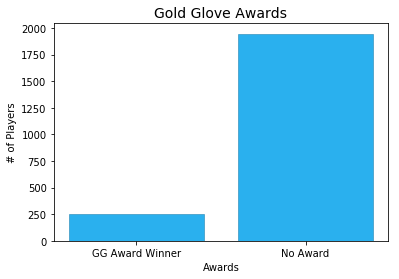

In [53]:
plt.bar(['GG Award Winner', 'No Award'], [sum(df_clean.Target==1), sum(df_clean.Target==0)], \
        facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.title('Gold Glove Awards', fontsize=14)
plt.xlabel('Awards')
plt.ylabel('# of Players')
plt.show()

The UZR/150 statistic is one of the most important all encompassing defensive statistics impacting whether or not a player will receive a gold glove award at the end of a season. According to Fangraphs.com:

Ultimate Zone Rating (UZR) is one of the most widely used, publicly available defensive statistics. UZR puts a run value to defense, attempting to quantify how many runs a player saved or gave up through their fielding prowess (or lack thereof). 

In this case, players who obtain a +15 UZR per 150 innings, should receive a gold glove award. Let's take a look at the distribution of this statistic amongst gold glove winners and non-gold glove winners. 

In [55]:
print('The average UZR/150 among non-winners is', np.mean(df_clean.loc[df_clean['Target'] == 0, ['UZR/150']])[0])

The average UZR/150 among non-winners is 0.25919835560123444


In [56]:
print('The average UZR/150 among winners is', np.mean(df_clean.loc[df_clean['Target'] == 1, ['UZR/150']])[0])

The average UZR/150 among winners is 6.458984375000004


In [70]:
print('The highest UZR/150 recorded in our data is', 
      np.max(df_clean.loc[df_clean['Target'] == 1, ['UZR/150']])[0], 'belonging to', 
      np.max(df_clean.loc[df_clean['Target'] == 1, ['Name']])[0], 'in the year', 
      np.max(df_clean.loc[df_clean['Target'] == 1, ['Season']])[0], 'where he played',
      np.max(df_clean.loc[df_clean['Target'] == 1, ['Inn']])[0], 'Innings.')

The highest UZR/150 recorded in our data is 27.9 belonging to Yunel Escobar in the year 2017 where he played 1458.0 Innings.


What about the rest of our statistics being used to measure a players likelihood of receiving an award at the end of a season? Here, we compare award winners and non-award winners average statistics to see how these players compare:

In [78]:
non_winners = np.mean(df_clean.loc[df_clean['Target'] == 0])
winners = np.mean(df_clean.loc[df_clean['Target'] == 1])
non_winners = non_winners.drop(['playerid', 'Season', 'Inn'])
winners = winners.drop(['playerid', 'Season', 'Inn'])

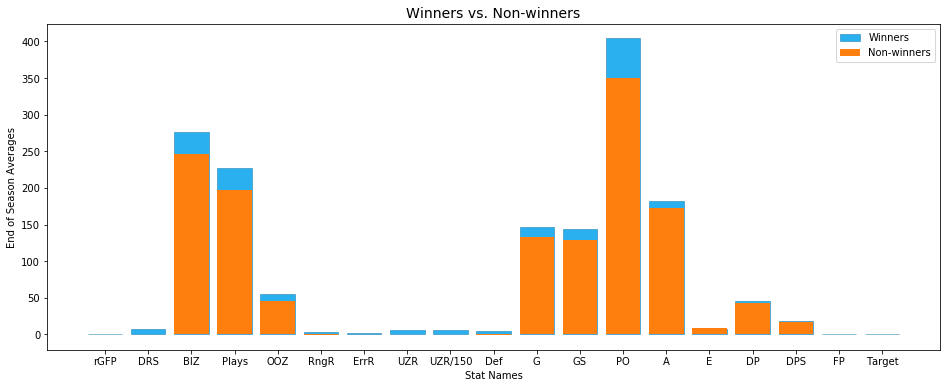

In [80]:
plt.figure(figsize=(16,6))
plt.bar(winners.keys(), winners.values, label='Winners', facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.bar(non_winners.keys(), non_winners.values, label='Non-winners')
plt.title('Winners vs. Non-winners', fontsize=14)
plt.xlabel('Stat Names')
plt.ylabel('End of Season Averages')
plt.legend()
plt.show()

As we can see, players who are given the gold glove awards have higher averages in every statistic except for errors. Which makes sense as committing an error would be a negative statistic and would not help a player receive an award. 

Text(0.5, 1.0, 'Fielding Percentage vs. Ultimate Zone Rating')

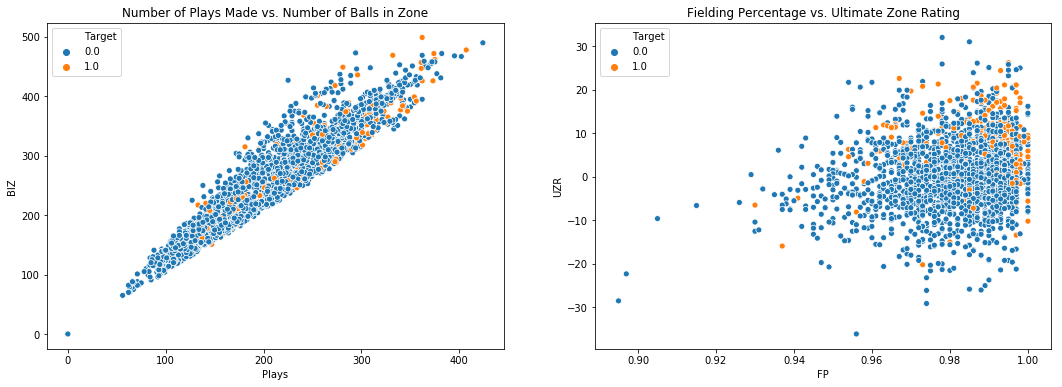

In [147]:
plt.figure(figsize=(18,6))

plt.subplot(121)
sns.scatterplot(df_clean['Plays'], df_clean['BIZ'], hue = df_clean['Target'])
plt.title('Number of Plays Made vs. Number of Balls in Zone')

plt.subplot(122)
sns.scatterplot(df_clean['FP'], df_clean['UZR'], hue = df_clean['Target'])
plt.title('Fielding Percentage vs. Ultimate Zone Rating')

Looking at the scatter plots above, we can see that Plays and BIZ are highly correlated. If you make a certain number of plays, you should have seen a similar number of balls in your fielding zone. However, the target variable is sprinkled througout this correlation, suggesting that there is a significant difference in these numbers due to positioning in the field. 

When looking at UZR vs. FP, minus some outliers, it is clear that most GG award winners will have a high FP and a high UZR. 

In [146]:
(df_clean['Name'].loc[df_clean['Target']==1].value_counts()).head(15)

Ichiro Suzuki      8
Adrian Gonzalez    7
Torii Hunter       7
Alex Gordon        5
Eric Chavez        5
Scott Rolen        5
Andruw Jones       5
Adrian Beltre      5
Mark Teixeira      5
Jason Heyward      5
Derek Jeter        5
Alex Rodriguez     5
Nolan Arenado      5
Jimmy Rollins      4
Orlando Hudson     4
Name: Name, dtype: int64

Looking at players who have received the GG award multiple seasons, Derek Jeter and Andruw Jones have each received a GG 5 times. However, 1 player is a Shortstop (Jeter) and the other a Center Fielder (Jones). Do the statistics that a player accumulates over seasons with GG awards vary by position? Let's take a look at these two players and their average statistics when they received a GG award. 

In [142]:
Jeter = np.mean(df_clean.loc[(df_clean['Name']=='Derek Jeter')&(df_clean['Target']==1)])
Jeter = Jeter.drop(['playerid', 'Season', 'Inn'])

Jones = np.mean(df_clean.loc[(df_clean['Name']=='Andruw Jones')&(df_clean['Target']==1)])
Jones = Jones.drop(['playerid', 'Season', 'Inn'])

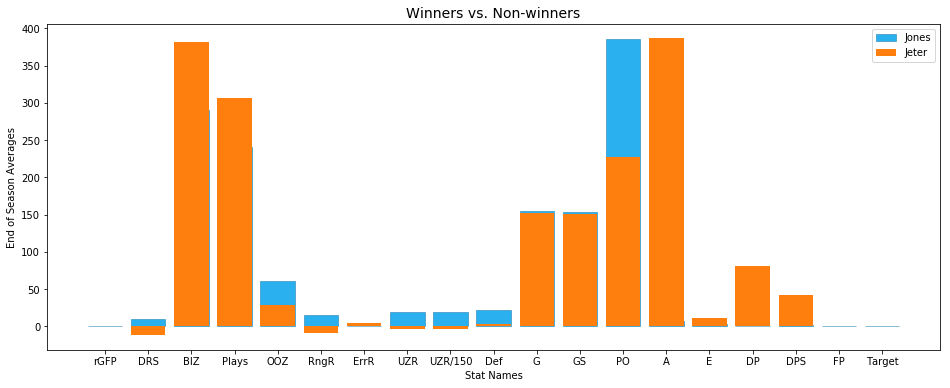

In [143]:
plt.figure(figsize=(16,6))
plt.bar(Jones.keys(), Jones.values, label='Jones', facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.bar(Jeter.keys(), Jeter.values, label='Jeter')
plt.title('Winners vs. Non-winners', fontsize=14)
plt.xlabel('Stat Names')
plt.ylabel('End of Season Averages')
plt.legend()
plt.show()

Position does appear to have an influence on these two players and the statistics they accumulate. For example, Andruw Jones nearly doubles the amount of put-outs Jeter accumulated. This is certainly due to the fact that a the ball is hit to a center fielder, more than it is to a shortstop. However, being in the infield allows Jeter to participate in more Plays. We will have to be sure to factor the impact of position in our model.

# Part 4: Model

### Baseline/initial models
- 4a. K Nearest Neighbors
- 4b. Decision Tree
- 4c. Random Forest

### Hyperparameter Tuning
- 4d. Random Forest Tuned w/ Grid Search

### ----------------------------------------------------------------------------------------------------------------

### 4a. KNN

In [149]:
# model
KNN = KNeighborsClassifier()

# train
KNN = KNN.fit(X_train, y_train)

# predict
KNN_train_preds = KNN.predict(X_train)
KNN_test_preds = KNN.predict(X_test)

# evaluate
KNN_train_accuracy = accuracy_score(y_train, KNN_train_preds)
KNN_test_accuracy = accuracy_score(y_test, KNN_test_preds)
KNN_test_precision = precision_score(y_test, KNN_test_preds)
KNN_test_F1 = f1_score(y_test, KNN_test_preds)
KNN_report = classification_report(y_test, KNN_test_preds)

# store accuracy in a new dataframe
score_KNN = ['KNN', KNN_train_accuracy, KNN_test_accuracy, KNN_test_precision, KNN_test_F1]
models1 = pd.DataFrame([score_KNN])

In [150]:
print('Classification Report K-Nearest Neighbors: \n', KNN_report)
print('------------------------------------------------------')
print('')
print("KNN")
print('------------------------------------------------------')
print(f"Training Accuracy: {(KNN_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(KNN_test_accuracy * 100):.4}%")

Classification Report K-Nearest Neighbors: 
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       486
         1.0       0.67      0.18      0.29        65

   micro avg       0.89      0.89      0.89       551
   macro avg       0.78      0.59      0.62       551
weighted avg       0.87      0.89      0.87       551

------------------------------------------------------

KNN
------------------------------------------------------
Training Accuracy: 89.95%
Test Accuracy:     89.29%


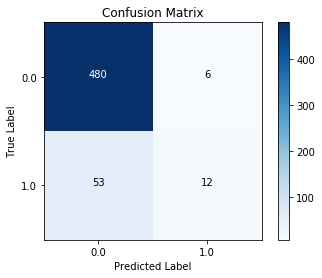

In [160]:
show_cf(y_test, KNN_test_preds)

### 4b. Decision Tree

In [161]:
# model
dt = DecisionTreeClassifier(random_state=10)  

# train
dt = dt.fit(X_train, y_train)

# predict
dt_train_preds = dt.predict(X_train)
dt_test_preds = dt.predict(X_test)

# evaluate
dt_train_accuracy = accuracy_score(y_train, dt_train_preds)
dt_test_accuracy = accuracy_score(y_test, dt_test_preds)
dt_test_precision = precision_score(y_test, dt_test_preds)
dt_test_F1 = f1_score(y_test, dt_test_preds)
dt_report = classification_report(y_test, dt_test_preds)

# append accuracy score to our dataframe
score_dt = ['Vanilla Decision Tree', dt_train_accuracy, dt_test_accuracy, dt_test_precision, dt_test_F1]
models1 = models1.append([score_dt])

In [162]:
print('Classification Report Vanilla Decision Tree: \n', dt_report)
print('------------------------------------------------------')
print('')
print('Vanilla Decision Tree')
print('------------------------------------------------------')
print(f"Training Accuracy: {(dt_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(dt_test_accuracy * 100):.4}%")

Classification Report Vanilla Decision Tree: 
               precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       486
         1.0       0.31      0.31      0.31        65

   micro avg       0.84      0.84      0.84       551
   macro avg       0.61      0.61      0.61       551
weighted avg       0.84      0.84      0.84       551

------------------------------------------------------

Vanilla Decision Tree
------------------------------------------------------
Training Accuracy: 100.0%
Test Accuracy:     83.67%


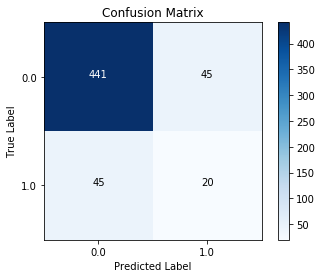

In [163]:
show_cf(y_test, dt_test_preds)

### 4c. Random Forest

In [164]:
# model
rfc = RandomForestClassifier()

# train
rfc = rfc.fit(X_train, y_train)

# predict
rfc_train_preds = rfc.predict(X_train)
rfc_test_preds = rfc.predict(X_test)

# evaluate
rfc_train_accuracy = accuracy_score(y_train, rfc_train_preds)
rfc_test_accuracy = accuracy_score(y_test, rfc_test_preds)
rfc_test_precision = precision_score(y_test, rfc_test_preds)
rfc_test_F1 = f1_score(y_test, rfc_test_preds)
rfc_report = classification_report(y_test, rfc_test_preds)

# append accuracy score to our dataframe
score_rfc = ['Random Forest', rfc_train_accuracy, rfc_test_accuracy, rfc_test_precision, rfc_test_F1]
models1 = models1.append([score_rfc])

/Users/Kelly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [165]:
print('Classification Report Random Forest: \n', rfc_report)
print('------------------------------------------------------')
print('')
print('Random Forest')
print('------------------------------------------------------')
print(f"Training Accuracy: {(rfc_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(rfc_test_accuracy * 100):.4}%")

Classification Report Random Forest: 
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.93       486
         1.0       0.30      0.05      0.08        65

   micro avg       0.87      0.87      0.87       551
   macro avg       0.59      0.52      0.51       551
weighted avg       0.82      0.87      0.83       551

------------------------------------------------------

Random Forest
------------------------------------------------------
Training Accuracy: 98.18%
Test Accuracy:     87.48%


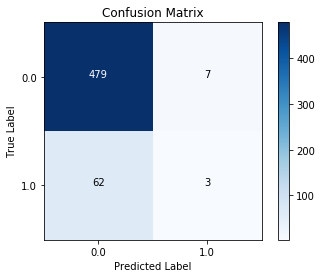

In [166]:
show_cf(y_test, rfc_test_preds)

### Hyperparameter Tuning Using Grid Search

- 4d. Random Forest w/ Grid Search

### 4d. Random Forest w/ Grid Search

In [167]:
# create parameter grid to search
param_grid = {'n_estimators':[70, 100, 120],
              'criterion':['gini', 'entropy'],
              'max_depth':[4, 5, 6],
              'min_samples_split':[2, 4],
              'max_features':['sqrt', 'log2']}

# run grid search
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [70, 100, 120], 'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6], 'min_samples_split': [2, 4], 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [168]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 120}

In [169]:
# model
rfc_tuned = RandomForestClassifier(criterion='gini', max_depth=4,
                             max_features='sqrt', min_samples_split=2,
                             n_estimators=120)

# train
rfc_tuned = rfc_tuned.fit(X_train, y_train)

# predict
rfc_tuned_train_preds = rfc_tuned.predict(X_train)
rfc_tuned_test_preds = rfc_tuned.predict(X_test)

# evaluate
rfc_tuned_train_accuracy = accuracy_score(y_train, rfc_tuned_train_preds)
rfc_tuned_test_accuracy = accuracy_score(y_test, rfc_tuned_test_preds)
rfc_tuned_test_precision = precision_score(y_test, rfc_tuned_test_preds)
rfc_tuned_test_F1 = f1_score(y_test, rfc_tuned_test_preds)
rfc_tuned_report = classification_report(y_test, rfc_tuned_test_preds)

# append accuracy score to our dataframe
score_rfc_tuned = ['Tuned Random Forest', rfc_tuned_train_accuracy, rfc_tuned_test_accuracy, rfc_tuned_test_precision, rfc_tuned_test_F1]
models1 = models1.append([score_rfc_tuned])

/Users/Kelly/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Kelly/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Kelly/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Kelly/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Kelly

In [170]:
print('Classification Report Tuned Random Forest: \n', rfc_tuned_report)
print('------------------------------------------------------')
print('')
print('Tuned Random Forest')
print('------------------------------------------------------')
print(f"Training Accuracy: {(rfc_tuned_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(rfc_tuned_test_accuracy * 100):.4}%")

Classification Report Tuned Random Forest: 
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       486
         1.0       0.00      0.00      0.00        65

   micro avg       0.88      0.88      0.88       551
   macro avg       0.44      0.50      0.47       551
weighted avg       0.78      0.88      0.83       551

------------------------------------------------------

Tuned Random Forest
------------------------------------------------------
Training Accuracy: 89.1%
Test Accuracy:     88.2%


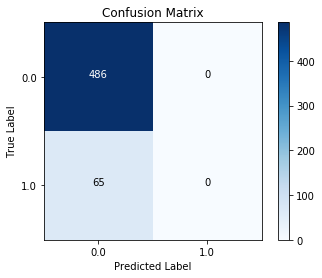

In [171]:
show_cf(y_test, rfc_tuned_test_preds)

### Ensemble methods
- 4e. Adaboost
- 4f. GradientBoost


### 4e. Adaboost

In [207]:
import warnings
warnings.filterwarnings("ignore")
# model
adaboost = AdaBoostClassifier()

# train
adaboost = adaboost.fit(X_train, y_train)

# predict
adaboost_train_preds = adaboost.predict(X_train)
adaboost_test_preds = adaboost.predict(X_test)

# evaluate
adaboost_train_accuracy = accuracy_score(y_train, adaboost_train_preds)
adaboost_test_accuracy = accuracy_score(y_test, adaboost_test_preds)
adaboost_test_precision = precision_score(y_test, adaboost_test_preds)
adaboost_test_F1 = f1_score(y_test, adaboost_test_preds)
adaboost_report = classification_report(y_test, adaboost_test_preds)

# append accuracy score to our dataframe
score_adaboost = ['Adaboost', adaboost_train_accuracy, adaboost_test_accuracy, adaboost_test_precision, adaboost_test_F1]
models1 = models1.append([score_adaboost])

In [208]:
print('Classification Report Adaboost: \n', adaboost_report)
print('------------------------------------------------------')
print('')
print('Adaboost')
print('------------------------------------------------------')
print(f"Training Accuracy: {(adaboost_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(adaboost_test_accuracy * 100):.4}%")

Classification Report Adaboost: 
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       492
         1.0       0.54      0.22      0.31        59

   micro avg       0.90      0.90      0.90       551
   macro avg       0.73      0.60      0.63       551
weighted avg       0.87      0.90      0.88       551

------------------------------------------------------

Adaboost
------------------------------------------------------
Training Accuracy: 89.34%
Test Accuracy:     89.66%


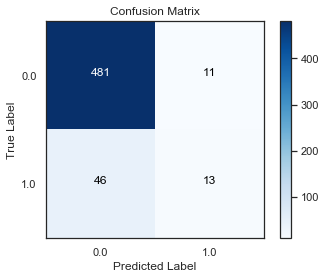

In [209]:
show_cf(y_test, adaboost_test_preds)

### 4f. Gradient Boost

In [175]:
# model
gbt = GradientBoostingClassifier()

# train
gbt = gbt.fit(X_train, y_train)

# predict
gbt_train_preds = gbt.predict(X_train)
gbt_test_preds = gbt.predict(X_test)

# evaluate
gbt_train_accuracy = accuracy_score(y_train, gbt_train_preds)
gbt_test_accuracy = accuracy_score(y_test, gbt_test_preds)
gbt_test_precision = precision_score(y_test, gbt_test_preds)
gbt_test_F1 = f1_score(y_test, gbt_test_preds)
gbt_report = classification_report(y_test, gbt_test_preds)

# append accuracy score to our dataframe
score_gbt = ['Gradient Boost', gbt_train_accuracy, gbt_test_accuracy, gbt_test_precision, gbt_test_F1]
models1 = models1.append([score_gbt])

In [176]:
print('Classification Report Gradient Boost: \n', gbt_report)
print('------------------------------------------------------')
print('')
print('Tuned Random Forest')
print('------------------------------------------------------')
print(f"Training Accuracy: {(gbt_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(gbt_test_accuracy * 100):.4}%")

Classification Report Gradient Boost: 
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       486
         1.0       0.71      0.18      0.29        65

   micro avg       0.89      0.89      0.89       551
   macro avg       0.80      0.59      0.62       551
weighted avg       0.88      0.89      0.87       551

------------------------------------------------------

Tuned Random Forest
------------------------------------------------------
Training Accuracy: 94.25%
Test Accuracy:     89.47%


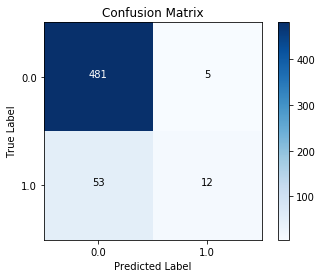

In [177]:
show_cf(y_test, gbt_test_preds)

# Part 5: Interpret
- Model Evaluation and comparison
- Feature engineering
- Final model
- Using the model to predict on the 2018 data

### Model Evaluation and comparison

Now that we have trained a few models, let's look at what works best. It appears that the Adaptive Boost ensemble method gives us a high training and testing accuracy, along with a high precision score and the 2nd highest overall F1 score. This is the model we will use. 

In [178]:
columns = ('Model', 'Training ACC', 'Testing ACC', 'Testing Precision', 'Testing F1')
models1.columns = columns
print(models1)
print('--------------------------------------------------------------------------')


                   Model  Training ACC  Testing ACC  Testing Precision  \
0                    KNN      0.899455     0.892922           0.666667   
0  Vanilla Decision Tree      1.000000     0.836661           0.307692   
0          Random Forest      0.978195     0.889292           0.642857   
0  Vanilla Decision Tree      1.000000     0.836661           0.307692   
0          Random Forest      0.981829     0.874773           0.300000   
0    Tuned Random Forest      0.890975     0.882033           0.000000   
0               Adaboost      0.897638     0.891107           0.575758   
0         Gradient Boost      0.942459     0.894737           0.705882   

   Testing F1  
0    0.289157  
0    0.307692  
0    0.227848  
0    0.307692  
0    0.080000  
0    0.000000  
0    0.387755  
0    0.292683  
--------------------------------------------------------------------------


### Feature Engineering

In this section, we will re-train the Adaptive Boosting model on improved data to see if we can see gains in the model's performance. Here, we will check for multicollinearity and remove any features with a correlation above 90. We will look at the model's feature importance and remove any features that are not important. Finally, we will re-scale and split the data to re-train the model to check for improvements. 

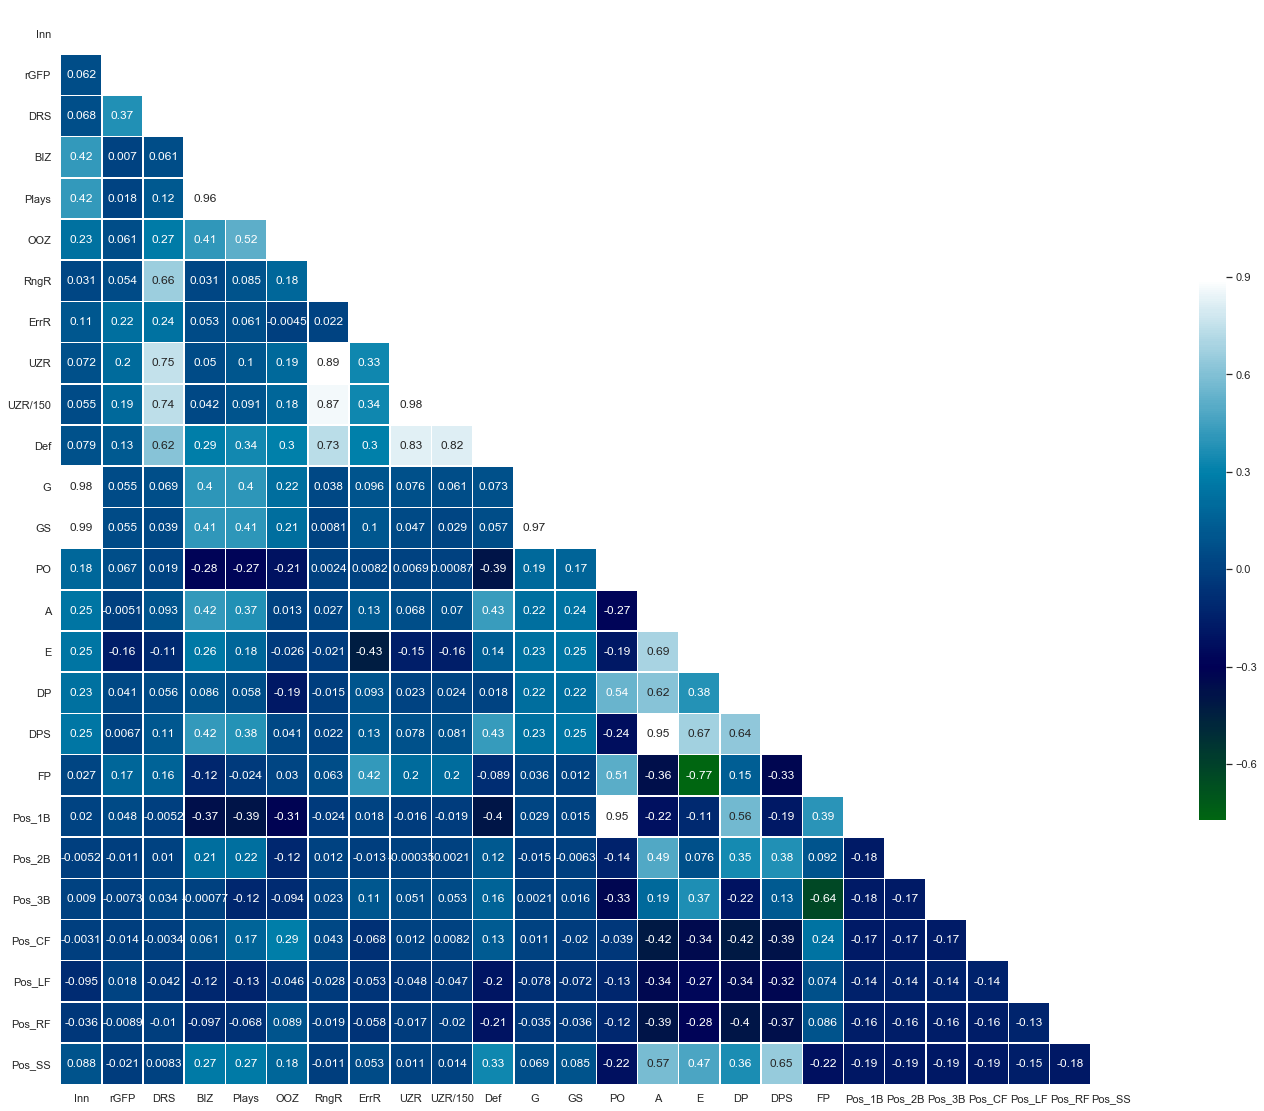

In [179]:
# create a correlation heat map 
sns.set(style = 'white')
corr = features.corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (24, 20))
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = 'ocean', vmax = .9, center = 0, 
            square = True, annot = True, linewidths = .5, cbar_kws = {'shrink': .5})

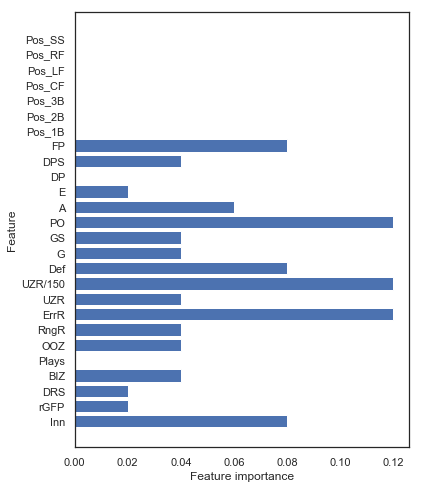

In [180]:
plot_feature_importances(adaboost)

In [197]:
# Dropping features that are overly correlated with each other and 
# features that are not important to the gbt model

features2 = features.drop(['Pos_1B',  'Pos_2B',  'Pos_3B',  'Pos_SS',  'Pos_LF', 'Pos_CF',  
                           'Pos_RF', 'RngR', 'G', 'GS', 'DP', 'DPS', 'Plays', 'A'], axis = 1, inplace = False)
holdout_features2 = holdout_features.drop(['Pos_1B',  'Pos_2B',  'Pos_3B',  'Pos_SS',  'Pos_LF', 'Pos_CF',  
                        'Pos_RF', 'RngR', 'G', 'GS', 'DP', 'DPS', 'Plays', 'A'], axis = 1, inplace = False)


In [198]:
# Scaling features

scaler = StandardScaler()
feature_importance = scaler.fit_transform(features2)

feature_importance_scaled_df = pd.DataFrame(feature_importance)
features2 = feature_importance_scaled_df

features2.head()

X_train, X_test, y_train, y_test = train_test_split(features2, target, test_size=0.25)

In [199]:
# Retraining the model 

# model
adaboost2 = AdaBoostClassifier()

# train
adaboost2 = adaboost2.fit(X_train, y_train)

# predict
adaboost2_train_preds = adaboost2.predict(X_train)
adaboost2_test_preds = adaboost2.predict(X_test)

# evaluate
adaboost2_train_accuracy = accuracy_score(y_train, adaboost2_train_preds)
adaboost2_test_accuracy = accuracy_score(y_test, adaboost2_test_preds)
adaboost2_test_precision = precision_score(y_test, adaboost2_test_preds)
adaboost2_test_F1 = f1_score(y_test, adaboost2_test_preds)
adaboost2_report = classification_report(y_test, adaboost2_test_preds)

# append accuracy score to our dataframe
score_adaboost2 = ['Adaboost 2', adaboost2_train_accuracy, adaboost2_test_accuracy, adaboost2_test_precision, adaboost2_test_F1]



In [200]:
print('Classification Report Gradient Boost: \n', adaboost2_report)
print('------------------------------------------------------')
print('')
print('Adaboost 2')
print('------------------------------------------------------')
print(f"Training Accuracy: {(adaboost2_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(adaboost2_test_accuracy * 100):.4}%")

Classification Report Gradient Boost: 
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       492
         1.0       0.54      0.22      0.31        59

   micro avg       0.90      0.90      0.90       551
   macro avg       0.73      0.60      0.63       551
weighted avg       0.87      0.90      0.88       551

------------------------------------------------------

Adaboost 2
------------------------------------------------------
Training Accuracy: 89.34%
Test Accuracy:     89.66%


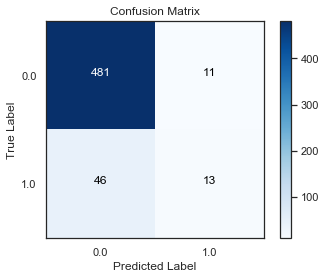

In [201]:
show_cf(y_test, adaboost2_test_preds)

In [202]:
print('Classification Report Gradient Boost: \n', adaboost_report)
print('------------------------------------------------------')
print('')
print('Adaboost')
print('------------------------------------------------------')
print(f"Training Accuracy: {(adaboost_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(adaboost_test_accuracy * 100):.4}%")

Classification Report Gradient Boost: 
               precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       486
         1.0       0.58      0.29      0.39        65

   micro avg       0.89      0.89      0.89       551
   macro avg       0.74      0.63      0.66       551
weighted avg       0.87      0.89      0.88       551

------------------------------------------------------

Adaboost
------------------------------------------------------
Training Accuracy: 89.76%
Test Accuracy:     89.11%


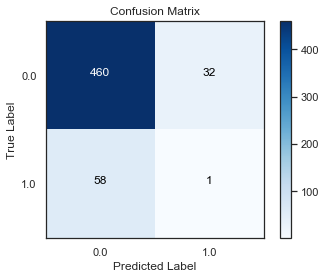

In [203]:
show_cf(y_test, adaboost_test_preds)

Using some feature engineering has changed the results of our model. As shown below the training accuracy has decreased but the testing has increased. Furthermore, our testing precision has decreased, as well as the overall F1 score of the model. It appears that the feature engineering that was conducted, had little influence on the model overall. We will stick with the original adaboost model to test our hold out dataset. 

In [204]:
models2 = pd.DataFrame([score_adaboost])
models2 = models2.append([score_adaboost2])
columns = ('Model', 'Training ACC', 'Testing ACC', 'Testing Precision', 'Testing F1')
models2.columns = columns
print(models2)
print('--------------------------------------------------------------------------')

        Model  Training ACC  Testing ACC  Testing Precision  Testing F1
0    Adaboost      0.897638     0.891107           0.575758    0.387755
0  Adaboost 2      0.893398     0.896552           0.541667    0.313253
--------------------------------------------------------------------------


### Using the Gradient Boost Model to Predict


In [222]:
df_holdout['Predictions'] = adaboost.predict(holdout_features2)

In [223]:
df_holdout.loc[(df_holdout['Predictions']==1)] 

,Season,Name,Team,Pos,Inn,rGFP,DRS,BIZ,Plays,OOZ,...,G,GS,PO,A,E,DP,DPS,FP,Target,Predictions
93,2018,Francisco Lindor,CLE,SS,1386.1,1.0,14.0,311.0,252.0,92.0,...,157.0,157.0,189.0,383.0,14.0,74.0,42.0,0.976,0.0,1.0
503,2018,Trea Turner,WSN,SS,1401.0,1.0,2.0,334.0,247.0,118.0,...,159.0,158.0,203.0,399.0,12.0,62.0,39.0,0.981,0.0,1.0
580,2018,Ender Inciarte,ATL,CF,1341.0,-1.0,17.0,283.0,268.0,112.0,...,155.0,151.0,380.0,6.0,5.0,0.0,3.0,0.987,1.0,1.0
1205,2018,Freddy Galvis,SDP,SS,1401.0,1.0,7.0,343.0,275.0,83.0,...,160.0,157.0,222.0,399.0,9.0,75.0,37.0,0.986,0.0,1.0
1541,2018,Matt Olson,OAK,1B,1403.1,3.0,14.0,205.0,175.0,19.0,...,162.0,152.0,1403.0,84.0,7.0,107.0,18.0,0.995,1.0,1.0
1880,2018,Freddie Freeman,ATL,1B,1415.0,1.0,12.0,168.0,143.0,38.0,...,161.0,160.0,1268.0,72.0,7.0,109.0,5.0,0.995,0.0,1.0
2008,2018,Nick Markakis,ATL,RF,1387.1,-1.0,2.0,222.0,209.0,104.0,...,158.0,157.0,312.0,9.0,2.0,0.0,0.0,0.994,1.0,1.0
2460,2018,Eric Hosmer,SDP,1B,1378.0,3.0,8.0,192.0,152.0,15.0,...,157.0,155.0,1231.0,106.0,4.0,105.0,13.0,0.997,0.0,1.0


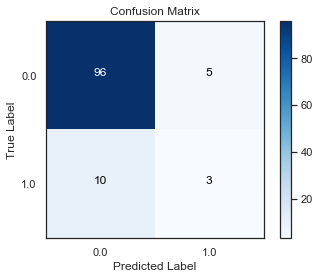

In [224]:
show_cf(df_holdout['Target'], adaboost.predict(holdout_features2))

# Conclusion

In the end, our baseline adaboost model correctly predicted 4 players. There were 9 players the model did not grant awards to when in reality, they were granted those awards. In addition, the model predicted 4 players to receive the award when they did not. However, 3 of those 4 players were finalists for the award. 

# Further Work

* Fine tune the baseline adaboost model with PCA, better feature engineering and hyperparameter tuning with a grid search. 
* Add more data, going back 10-20 seasons to accumulate more statistics.
* Test model on upcoming 2019 season awards.
* Test out XGBoost algorithm and compare with the baseline adaboost model.